In [207]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


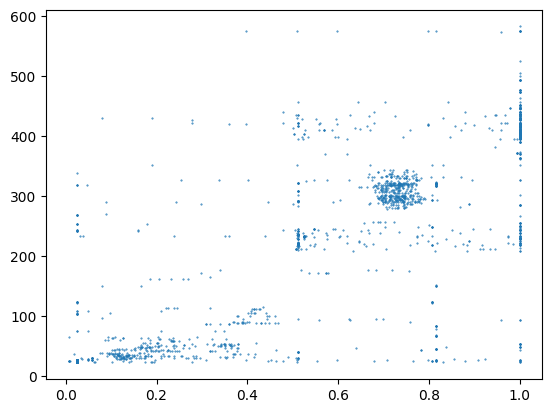

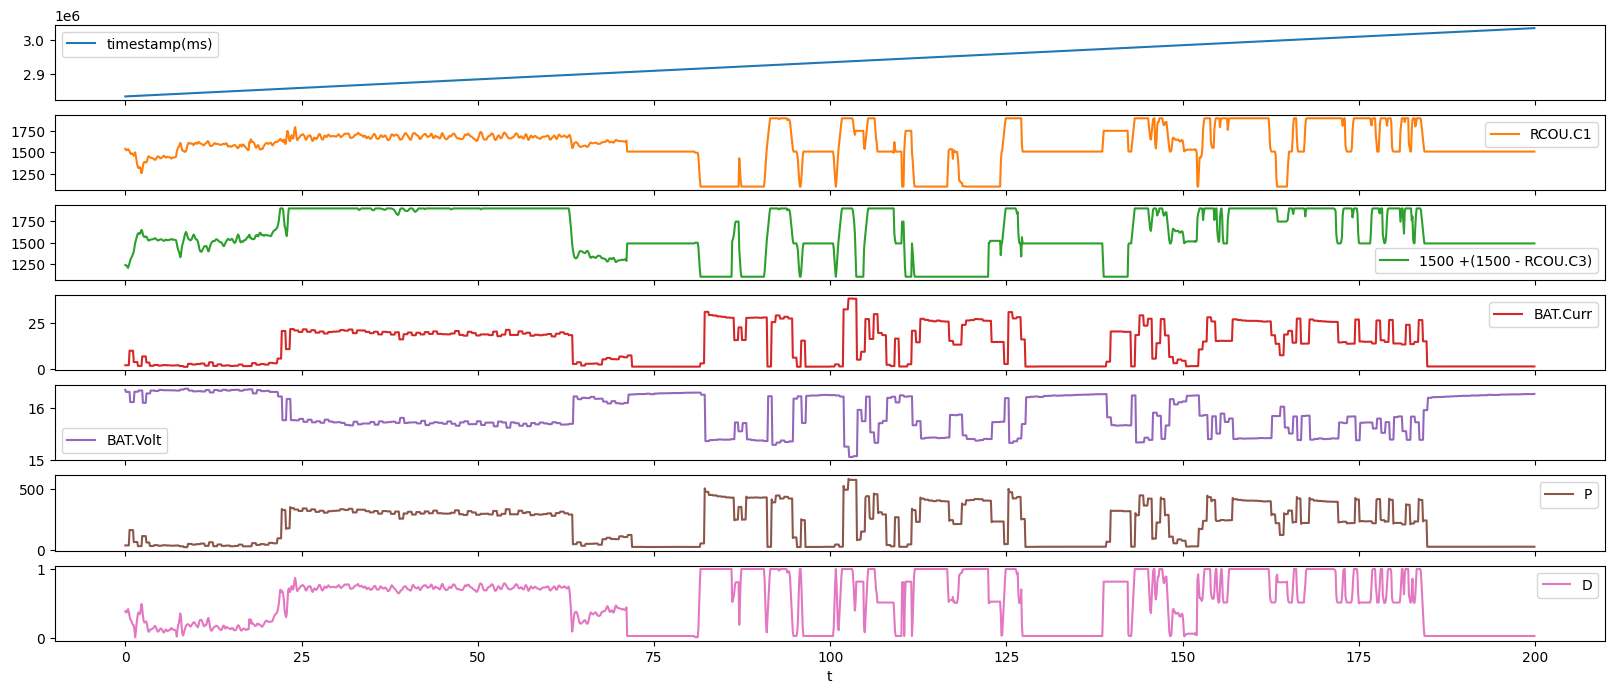

In [234]:
df = pd.read_csv("data.csv")
df = df.iloc[-2000:]

df['t'] = df['timestamp(ms)'] * 1e-3
df['t'] = df['t'] - df['t'].iloc[0]
df = df.set_index('t', drop=True)

df['P'] = df['BAT.Curr'] * df['BAT.Volt']

df['D'] = abs((df['RCOU.C1'] - 1500) / ((1900 - 1100) / 2))
df['D'] += abs((df['1500 +(1500 - RCOU.C3)'] - 1500) / ((1900 - 1100) / 2))
df['D'] /= 2
# df['D'] = 1 - df['D']

dt = np.diff(df.index).mean().round(6)

plt.figure()
plt.scatter(df['D'], df['P'], s=0.2)

df.plot(subplots=True, figsize=(20, 8))
plt.show()

[]

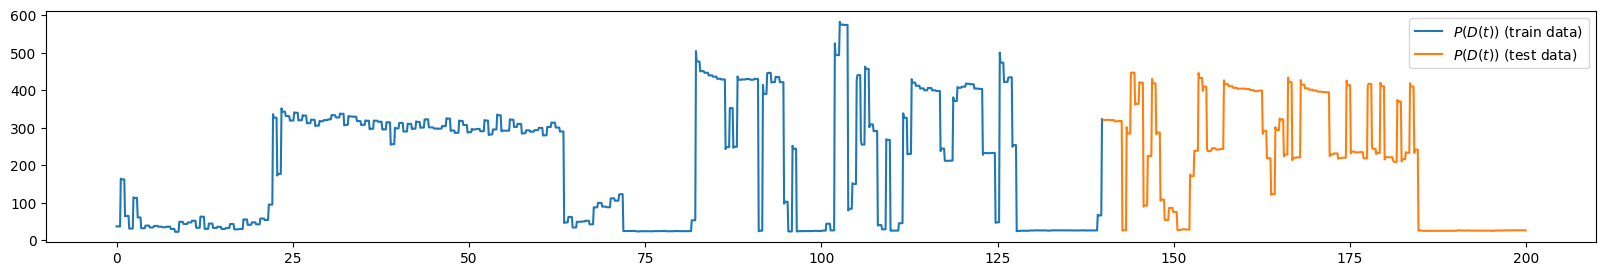

In [235]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from nfoursid.nfoursid import NFourSID

pd.set_option('display.max_columns', None)
np.random.seed(0)  # reproducable results

# Store only useful columns
u_column_names = ["D"]
y_column_names = ["P"]
df = df[[*u_column_names, *y_column_names]]

# Slipt train/test
train_size = int(len(df) * 0.7)
df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:]

plt.figure(figsize=(20, 3))
plt.plot(df_train[y_column_names], label='$P(D(t))$ (train data)')
plt.plot(df_test[y_column_names], label='$P(D(t))$ (test data)')
plt.legend(loc=1)
plt.plot()

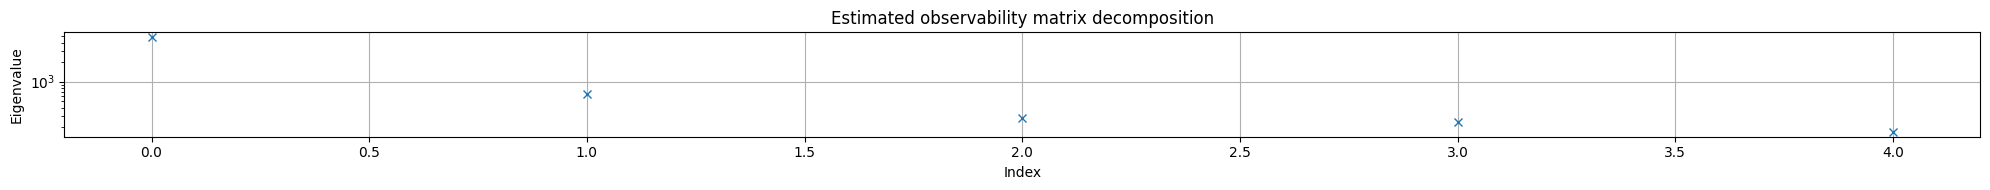

In [218]:
# Create and identify the model
nfoursid = NFourSID(
    df_train,
    output_columns=y_column_names,
    input_columns=u_column_names,
    num_block_rows=5
)
nfoursid.subspace_identification()

fig, ax = plt.subplots(figsize=(20,2))
nfoursid.plot_eigenvalues(ax)
fig.tight_layout()

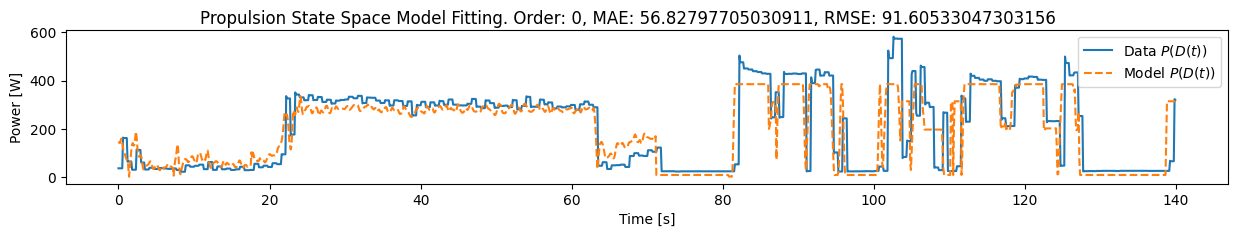

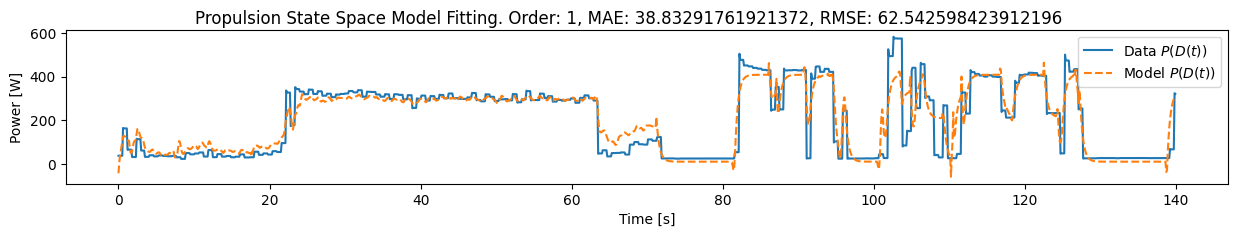

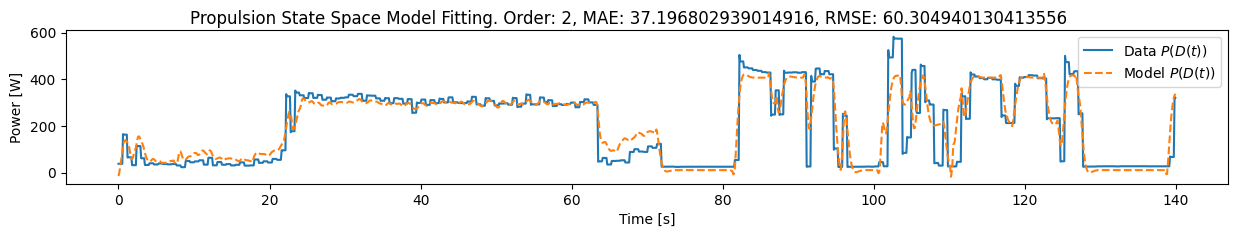

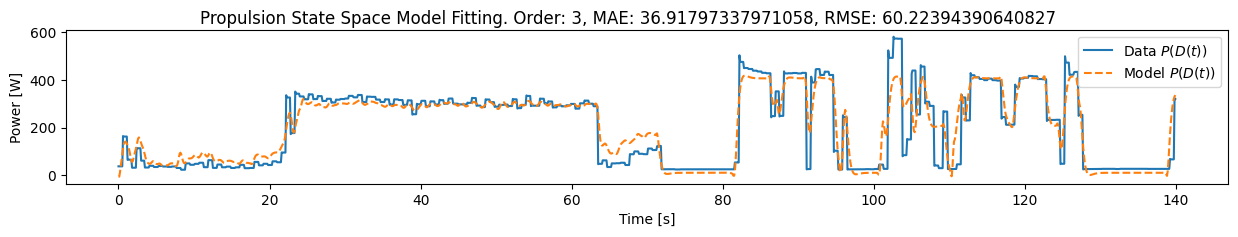

In [236]:
for ORDER_OF_MODEL_TO_FIT in range(4):
    nfoursid = NFourSID(
        df_train,
        output_columns=y_column_names,
        input_columns=u_column_names,
        num_block_rows=ORDER_OF_MODEL_TO_FIT + 10,
    )
    nfoursid.subspace_identification()

    state_space_identified, covariance_matrix = nfoursid.system_identification(
        rank=ORDER_OF_MODEL_TO_FIT
    )

    T = np.linspace(0, (len(df_train) -1)*dt, num=len(df_train))  # simulation time in seconds
    U = df_train[[*u_column_names]].to_numpy()
    for i in range(len(U)):
        state_space_identified.step(U[i].reshape(1,1))

    df_pred = state_space_identified.to_dataframe()

    rmse = (((df_train.to_numpy() - df_pred.to_numpy())**2).sum() / len(df_train))**(1/2)
    mae = abs(df_train.to_numpy() - df_pred.to_numpy()).sum() / len(df_train)

    plt.figure(figsize=(15,2))
    plt.plot(T, df_train["P"], label="Data $P(D(t))$")
    plt.plot(T, df_pred["$y_0$"], "--", label="Model $P(D(t))$")
    plt.legend(loc=1)
    plt.suptitle(f"Propulsion State Space Model Fitting. Order: {ORDER_OF_MODEL_TO_FIT}, MAE: {mae}, RMSE: {rmse}")
    plt.xlabel('Time [s]')
    plt.ylabel('Power [W]')
    plt.show()


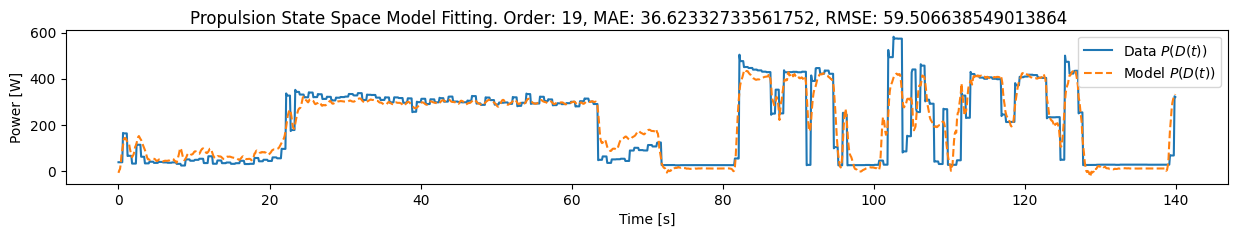

In [269]:
ORDER_OF_MODEL_TO_FIT = 19

nfoursid = NFourSID(
    df_train,
    output_columns=y_column_names,
    input_columns=u_column_names,
    num_block_rows=ORDER_OF_MODEL_TO_FIT + 1,
)
nfoursid.subspace_identification()

state_space_identified, covariance_matrix = nfoursid.system_identification(
    rank=ORDER_OF_MODEL_TO_FIT
)

T = np.linspace(0, (len(df_train) -1)*dt, num=len(df_train))  # simulation time in seconds
U = df_train[[*u_column_names]].to_numpy()
for i in range(len(U)):
    state_space_identified.step(U[i].reshape(1,1))

df_pred = state_space_identified.to_dataframe()

rmse = (((df_train.to_numpy() - df_pred.to_numpy())**2).sum() / len(df_train))**(1/2)
mae = abs(df_train.to_numpy() - df_pred.to_numpy()).sum() / len(df_train)

plt.figure(figsize=(15,2))
plt.plot(T, df_train["P"], label="Data $P(D(t))$")
plt.plot(T, df_pred["$y_0$"], "--", label="Model $P(D(t))$")
plt.legend(loc=1)
plt.suptitle(f"Propulsion State Space Model Fitting. Order: {ORDER_OF_MODEL_TO_FIT}, MAE: {mae}, RMSE: {rmse}")
plt.xlabel('Time [s]')
plt.ylabel('Power [W]')
plt.show()


StateSpace(array([[ 8.38066841e-01,  3.17915160e-02,  9.04958337e-02,
         3.20911705e-02, -2.10446038e-02,  1.26957624e-02,
        -1.45795470e-04,  2.02938105e-02, -1.76352633e-02,
         3.09095178e-02, -3.53220912e-02, -4.43414904e-03,
         2.12106058e-02,  6.23559495e-03, -2.40028805e-02,
        -1.45569931e-02, -6.81863813e-03, -1.99842172e-02,
         1.58964406e-02],
       [-2.21370060e-01,  9.32421474e-01, -1.55061879e-01,
         7.47117852e-02,  2.45539234e-02,  7.85217660e-03,
         1.83080499e-02, -3.87115592e-02, -3.12438988e-02,
         1.82521193e-01, -2.81960336e-01, -1.25439618e-01,
         6.35823468e-02,  1.08449877e-02,  7.54628806e-02,
        -2.38871879e-02, -7.46200954e-03, -1.95446591e-01,
         4.94664142e-02],
       [-2.32215133e-01,  7.86382181e-03,  8.33134744e-01,
        -2.95287189e-01,  1.00414419e-01, -1.64418555e-01,
         1.20593148e-02, -1.24547001e-01, -2.39353554e-02,
         5.25646578e-02, -1.83649816e-01, -1.9382422

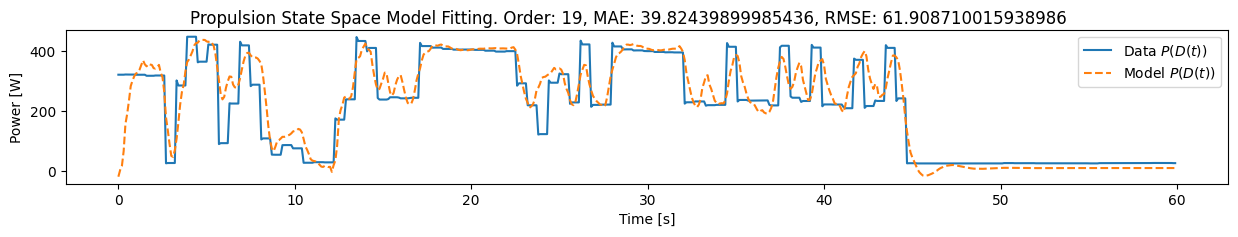

In [270]:
import control as ct

sys = ct.StateSpace(
    state_space_identified.a,
    state_space_identified.b,
    state_space_identified.c,
    state_space_identified.d,
    inputs=u_column_names,
    outputs=y_column_names,
    dt=dt,
)
display(sys)

T = np.linspace(0, (len(df_test) -1)*dt, num=len(df_test))  # simulation time in seconds
U = df_test[[*u_column_names]].to_numpy().T

res = ct.forced_response(sys, T, U=U)
res.output_labels = sys.output_labels
res.input_labels = sys.input_labels
res.state_labels = sys.state_labels
df_pred = res.to_pandas().set_index("time")

rmse = (((df_test[[*y_column_names]].to_numpy() - df_pred[[*y_column_names]].to_numpy())**2).sum() / len(df_test))**(1/2)
mae = abs(df_test[[*y_column_names]].to_numpy() - df_pred[[*y_column_names]].to_numpy()).sum() / len(df_test)

plt.figure(figsize=(15,2))
plt.plot(T, df_test["P"], label="Data $P(D(t))$")
plt.plot(T, df_pred[[*y_column_names]], "--", label="Model $P(D(t))$")
plt.legend(loc=1)
plt.suptitle(f"Propulsion State Space Model Fitting. Order: {ORDER_OF_MODEL_TO_FIT}, MAE: {mae}, RMSE: {rmse}")
plt.xlabel('Time [s]')
plt.ylabel('Power [W]')
plt.show()
